# Analysis of network growth

## Load data

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import random
from tqdm import tqdm
import scipy

In [2]:
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')

## Prepare temporal graphs

We define the range of study from 1890 to 2010 to prevent border effects from the dataset (years close to the border might not be representative)

In [3]:
# years_bins = list(range(1890, 2010+1, 2))
# print(years_bins)

### Purge unwanted edges

In [4]:
df_edges['movie_release_year'] = df_movies.set_index('fb_id').loc[df_edges.movie_fbid].movie_release_year.values
df_edges.sort_values('movie_release_year', inplace=True)

# we drop the movies release outside our period of study

print(f'length before purge : {len(df_edges)}')
df_edges.dropna(subset='movie_release_year', inplace=True)
# df_edges.drop(index=df_edges[((df_edges.movie_release_year <= min(years_bins)) | (df_edges.movie_release_year > max(years_bins)))].index, inplace=True)
df_edges.drop(index=df_edges[(df_edges.movie_release_year > 2015)].index, inplace=True)
print(f'length after purge : {len(df_edges)}')

# assert min(years_bins) < df_edges.movie_release_year.min()
# assert df_edges.movie_release_year.max() <= max(years_bins)

df_edges

length before purge : 2241657
length after purge : 2224824


,actor1_fbid,actor2_fbid,movie_fbid,movie_release_year
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888
678021,/m/0k2pz6,/m/0k2pzd,/m/044ggd,1888
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888
...,...,...,...,...
2103479,/m/07c90c,/m/090_4l,/m/0gys9tc,2015
2103478,/m/03m2fg,/m/05s_996,/m/0gys9tc,2015
2103477,/m/0274f0x,/m/03m2fg,/m/0gys9tc,2015
2103464,/m/02y_491,/m/05wdcz,/m/0gys9tc,2015


### Perform binning

In [5]:
# df_edges['bin'] = pd.cut(df_edges['movie_release_year'], years_bins)
# df_edges

In [6]:
# examine the size of the bins (number of movies inside the bin)
# df_edges.groupby('bin')[['movie_fbid']].nunique()

## Model growth

We consider the initial actor network at the year 1900

https://barabasi.com/f/622.pdf

Is there preferential attachment ?

### Numerical indices

In [7]:
codes, uniques = pd.factorize(pd.concat([df_edges.actor1_fbid, df_edges.actor2_fbid]))
df_edges['actor1_numid'] = codes[:len(df_edges)]
df_edges['actor2_numid'] = codes[len(df_edges):]
df_edges

,actor1_fbid,actor2_fbid,movie_fbid,movie_release_year,actor1_numid,actor2_numid
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888,0,1
678021,/m/0k2pz6,/m/0k2pzd,/m/044ggd,1888,1,119615
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888,2,1
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888,2,0
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888,0,119615
...,...,...,...,...,...,...
2103479,/m/07c90c,/m/090_4l,/m/0gys9tc,2015,79052,45830
2103478,/m/03m2fg,/m/05s_996,/m/0gys9tc,2015,28778,113761
2103477,/m/0274f0x,/m/03m2fg,/m/0gys9tc,2015,68210,28778
2103464,/m/02y_491,/m/05wdcz,/m/0gys9tc,2015,47720,51499


In [24]:
print(f'total {uniques.nunique()} nodes (actors)')

total 134649 nodes (actors)


### Compute degree evolution

In [56]:
# do binning every year
years = list(range(1900, 2015))
print(years)

[1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


In [57]:
def get_edges_year(year: int) -> pd.DataFrame:
	"""Return weighted edges for all movies released before and on ``year``"""
	return (df_edges
		.query(f'movie_release_year <= {year}')
		.groupby(['actor1_numid', 'actor2_numid'])
		[['movie_fbid']]
		.nunique()
		.reset_index()
		.rename(columns={'movie_fbid': 'movie_count'})
	)

#### Initial graph

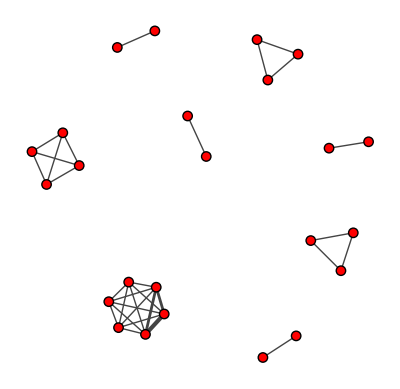

In [58]:
random.seed(0)  # seed the random layout
fig, ax = plt.subplots()
g0 = ig.Graph.DataFrame(get_edges_year(years[0])[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
ig.plot(g0, target=ax,
	# vertex_label=g0.vs['name'], vertex_label_size=7,
	edge_width=g0.es['movie_count']
);

#### Run computation

Note : actors keep their degree even after they die !

In [59]:
degrees = np.zeros((uniques.nunique(), len(years)))

for iyear, year in tqdm(enumerate(years)):
	g = ig.Graph.DataFrame(get_edges_year(year)[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
	# print(g.summary())
	for node, k in zip(g.vs, g.degree()):
		degrees[node['name'], iyear] = k

115it [00:45,  2.51it/s]


### Degree evolution

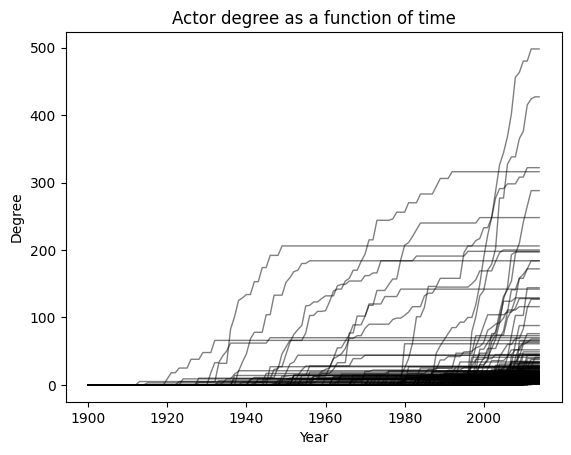

In [60]:
fig, ax = plt.subplots()
np.random.seed(0)
# we plot only 256 actors because plotting all 1.3M of them would take ages !!
ax.plot(years, degrees[np.random.randint(0, len(degrees), 256)].T, color='black', alpha=0.5, linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.set_title('Actor degree as a function of time')
plt.show()

The degree seems to grow linearly in time, but faster when actors enter late into the graph !

TODO : explore this more !

In [61]:
delta_degrees = np.diff(degrees, axis=-1)

In [71]:
np.random.seed(0)
indices = np.random.randint(0, len(degrees), 256)
degrees_ = degrees[indices]
delta_degrees_ = delta_degrees[indices]

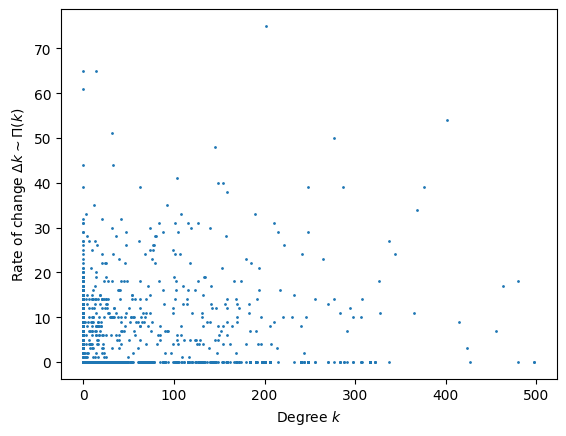

In [78]:
fig, ax = plt.subplots()
ax.plot(degrees_[:, :-1].flat, delta_degrees_.flat, 'o', markersize=1)
ax.set_xlabel('Degree $k$')
ax.set_ylabel('Rate of change $\\Delta k \\sim \Pi(k)$')
plt.show()

TODO : plot with color representing the year of release of the movie, filter by year, remove zero rate of change before and after actor life